In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False,input_shape=(224,224,3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [2]:
import glob
import pandas as pd
#先不讀取圖片，真的要訓練才讀
df = pd.DataFrame(columns=["path","target"])
for p in glob.glob("train/cat.*.jpg"):
    s = pd.Series([p,0], index=["path","target"])
    df = df.append(s,ignore_index=True)
for p in glob.glob("train/dog.*.jpg"):
    s = pd.Series([p,1], index=["path","target"])
    df = df.append(s,ignore_index=True)  
df

,path,target
0,train\cat.0.jpg,0
1,train\cat.1.jpg,0
2,train\cat.10.jpg,0
3,train\cat.100.jpg,0
4,train\cat.1000.jpg,0
...,...,...
24995,train\dog.9995.jpg,1
24996,train\dog.9996.jpg,1
24997,train\dog.9997.jpg,1
24998,train\dog.9998.jpg,1


train\dog.87.jpg
(499, 375)


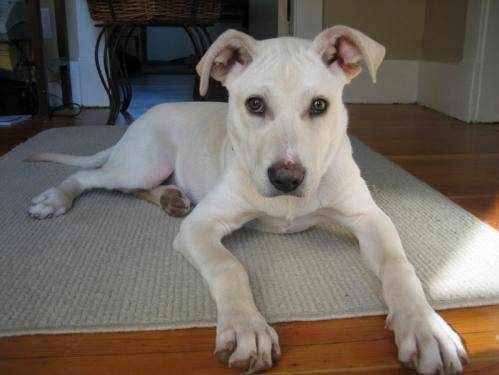

In [3]:
from tensorflow.keras.preprocessing.image import load_img
import random
c = random.randint(0,25000-1)
print(df["path"][c])
img = load_img(df["path"][c])
print(img.size)
img

(224, 224)


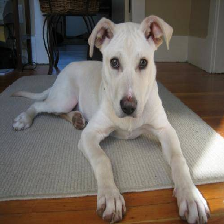

In [4]:
img = load_img(df["path"][c],target_size=(224,224))
print(img.size)
img

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization
#CNN(眼睛)
for l in vgg.layers:
    l.trainable = False
#Batch Normalization(血管)
x = BatchNormalization()(vgg.output)
#MLP(大腦)
x = Flatten()(x)
x = Dense(units=2048,activation="relu")(x)
x = Dense(units=256,activation="relu")(x)
#貓和狗分類
#第一種方法:units = 1 (sigmoid)
#第二種方法:units = 2 (softmax)
x = Dense(units=2,activation="softmax")(x)
cnn = Model(inputs=vgg.input,outputs=x)
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
vgg.layers[-1]

In [7]:
cnn.compile(loss="categorical_crossentropy",
           optimizer="Adam",
           metrics=["accuracy"])

In [8]:
#先處理一下答案，把它轉化成為one-hot-encoding
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(df["target"])

from sklearn.model_selection import train_test_split
#真的要開始切分和訓練的時候，請你把你的pandas轉成numpy的array
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(y_cat),
                                                    test_size=0.1)
#show一個y_train給你看
y_train[0]

array([1., 0.], dtype=float32)

In [9]:
#你借用誰的模型，就要使用他的預處理方式
from tensorflow.keras.applications.vgg16 import preprocess_input
batch_size = 20
for i in range(10):
    # random.randint(下限(包括),上限(不包括),幾個)
    idx = np.random.randint(0,x_train.shape[0],batch_size)
    #numpy好用之處:array[ 索引list ]
    img_list = []
    for fn in x_train[idx]:
        #讀取圖片並且使用我們借來的模型的預處理方式來處理遺下
        img = load_img(fn,target_size=(224,224))
        img = preprocess_input(np.array(img))
        img_list.append(img)
    # img_list
    x = np.array(img_list)
    y = y_train[idx]
    result = cnn.train_on_batch(x,y)
    print("-----Times",i,"-----")
    print(result)

-----Times 0 -----
[1.4030759, 0.5]
-----Times 1 -----
[7.5966873, 0.5]
-----Times 2 -----
[8.007561, 0.5]
-----Times 3 -----
[6.5088935, 0.6]
-----Times 4 -----
[7.833735, 0.45]
-----Times 5 -----
[2.2616253, 0.75]
-----Times 6 -----
[2.5184007, 0.75]
-----Times 7 -----
[4.119681, 0.7]
-----Times 8 -----
[3.9605966, 0.65]
-----Times 9 -----
[2.6213431, 0.8]


In [10]:
# x_train.shape[0]

In [11]:
batch_size = 100

# random.randint(下限(包括),上限(不包括),幾個)
idx = np.random.randint(0,x_test.shape[0],batch_size)
#numpy好用之處:array[ 索引list ]
img_list = []
ori_img_list = []
for fn in x_test[idx]:
    #讀取圖片並且使用我們借來的模型的預處理方式來處理遺下
    img = load_img(fn,target_size=(224,224))
    #先把原圖留下來
    ori_img_list.append(img)
    img = preprocess_input(np.array(img))
    img_list.append(img)
# img_list
x = np.array(img_list)
y = y_test[idx]
cnn.evaluate(x,y)


100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[14.049152374267578, 0.89]

In [12]:
# x_test[idx]

In [13]:
cnn.predict(x)

array([[0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [7.57597387e-01, 2.42402598e-01],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.10390097e-38],
       [1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.000000

In [14]:
#作圖
pre = cnn.predict(x).argmax(axis=-1)
pre

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [15]:
y.argmax(axis=-1)

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [16]:
np.nonzero(pre != y.argmax(axis=-1))

(array([ 3, 27, 41, 44, 48, 59, 65, 68, 70, 72, 74], dtype=int64),)